# Evaluation script

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paths (relatifs au dossier notebooks/)
DATA_DIR = Path("../data/processed")
PRED_DIR = DATA_DIR / "predictions"
PLOT_DIR = DATA_DIR / "plots"
EVAL_DIR = DATA_DIR / "evaluation"

PLOT_DIR.mkdir(exist_ok=True)
EVAL_DIR.mkdir(exist_ok=True)

In [3]:
y_true_csi = np.load(PRED_DIR / "y_true_csi.npy")
y_pred_csi = np.load(PRED_DIR / "y_pred_csi.npy")
timestamps = np.load(PRED_DIR / "timestamps.npy", allow_pickle=True)

print("y_true_csi:", y_true_csi.shape)
print("y_pred_csi:", y_pred_csi.shape)
print("timestamps:", timestamps.shape)


y_true_csi: (146, 6)
y_pred_csi: (146, 6)
timestamps: (146, 6)


In [4]:
FREQ_MIN = 10          # résolution temporelle (10 min)
HORIZONS = y_true_csi.shape[1]

horizons_min = [(h + 1) * FREQ_MIN for h in range(HORIZONS)]
horizons_min


[10, 20, 30, 40, 50, 60]

In [5]:
ground_csv = next((DATA_DIR / "ground").glob("*_clean.csv"))

gdf = pd.read_csv(ground_csv)
gdf["time"] = pd.to_datetime(gdf["time"])
gdf = gdf.set_index("time")

gdf.head()


,irradiance,ghi_clear,irradiance_csi,station
time,,,,
2020-01-01 08:00:00,12.0,30.721315,0.390608,PUY
2020-01-01 08:10:00,15.0,47.450132,0.316121,PUY
2020-01-01 08:20:00,18.0,65.803684,0.273541,PUY
2020-01-01 08:30:00,22.0,85.013611,0.258782,PUY
2020-01-01 08:40:00,25.0,104.534777,0.239155,PUY


In [7]:
PAST = 18  # doit matcher cfg["past_timesteps"]
N, H = y_true_csi.shape

# 1) extraire la série ghi_clear dans l'ordre temporel
ghi_clear_series = gdf["ghi_clear"].values

# 2) reconstruire ghi_clear par fenêtre (comme dans predict.py)
ghi_clear = np.zeros((N, H), dtype=np.float32)

for k in range(N):
    ghi_clear[k, :] = ghi_clear_series[k + PAST : k + PAST + H]

ghi_clear.shape


(146, 6)

In [8]:
y_true_ghi = y_true_csi * ghi_clear
y_pred_ghi = y_pred_csi * ghi_clear


In [9]:
rows = []

for h in range(H):
    err = y_pred_ghi[:, h] - y_true_ghi[:, h]

    rows.append({
        "horizon_min": horizons_min[h],
        "RMSE": np.sqrt(np.mean(err**2)),
        "MAE": np.mean(np.abs(err)),
        "MBE": np.mean(err),
    })

metrics = pd.DataFrame(rows)
metrics


,horizon_min,RMSE,MAE,MBE
0,10,35.558498,23.666342,1.511211
1,20,37.991352,25.285763,3.099660
2,30,39.810326,27.276976,0.595548
3,40,41.259258,28.855522,1.404007
4,50,41.866817,29.208292,4.772579
5,60,43.855278,29.986702,8.935232


In [10]:
metrics.to_csv(EVAL_DIR / "metrics_per_horizon.csv", index=False)
metrics


,horizon_min,RMSE,MAE,MBE
0,10,35.558498,23.666342,1.511211
1,20,37.991352,25.285763,3.099660
2,30,39.810326,27.276976,0.595548
3,40,41.259258,28.855522,1.404007
4,50,41.866817,29.208292,4.772579
5,60,43.855278,29.986702,8.935232


In [ ]:
def plot_metric(df, metric, out_path):
    plt.figure()
    plt.plot(df["horizon_min"], df[metric], marker="o")
    plt.xlabel("Forecast horizon (min)")
    plt.ylabel(metric)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()

plot_metric(metrics, "RMSE", PLOT_DIR / "rmse_vs_horizon.png")
plot_metric(metrics, "MAE",  PLOT_DIR / "mae_vs_horizon.png")
plot_metric(metrics, "MBE",  PLOT_DIR / "mbe_vs_horizon.png")


,horizon_min,RMSE,MAE,MBE
0,10,35.558498,23.666342,1.511211
1,20,37.991352,25.285763,3.099660
2,30,39.810326,27.276976,0.595548
3,40,41.259258,28.855522,1.404007
4,50,41.866817,29.208292,4.772579
5,60,43.855278,29.986702,8.935232


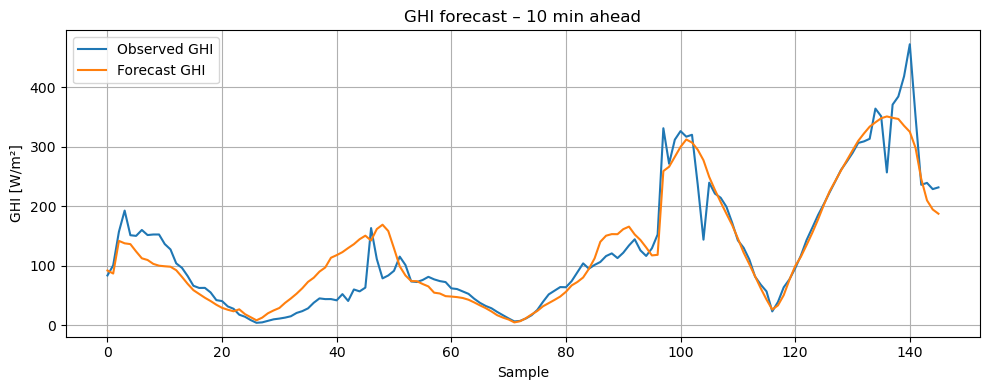

In [12]:
h = 0  # horizon index

plt.figure(figsize=(10,4))
plt.plot(y_true_ghi[:500, h], label="Observed GHI")
plt.plot(y_pred_ghi[:500, h], label="Forecast GHI")
plt.title("GHI forecast – 10 min ahead")
plt.xlabel("Sample")
plt.ylabel("GHI [W/m²]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(PLOT_DIR / "forecast_10min.png")
plt.show()


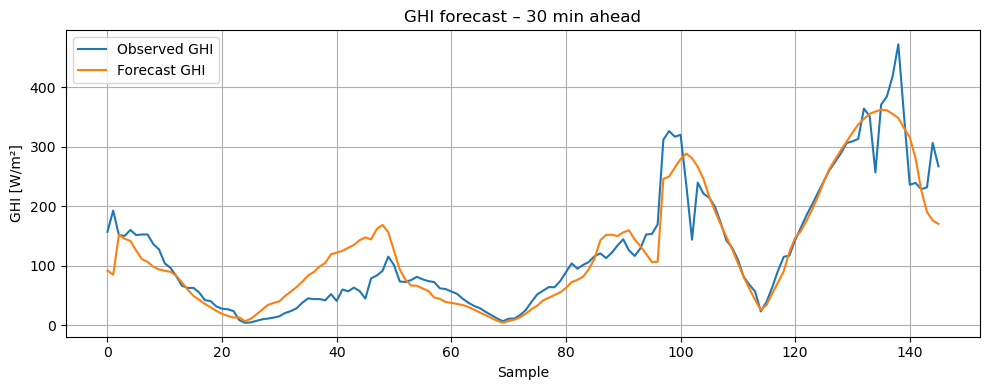

In [13]:
h = 2

plt.figure(figsize=(10,4))
plt.plot(y_true_ghi[:500, h], label="Observed GHI")
plt.plot(y_pred_ghi[:500, h], label="Forecast GHI")
plt.title("GHI forecast – 30 min ahead")
plt.xlabel("Sample")
plt.ylabel("GHI [W/m²]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(PLOT_DIR / "forecast_30min.png")
plt.show()


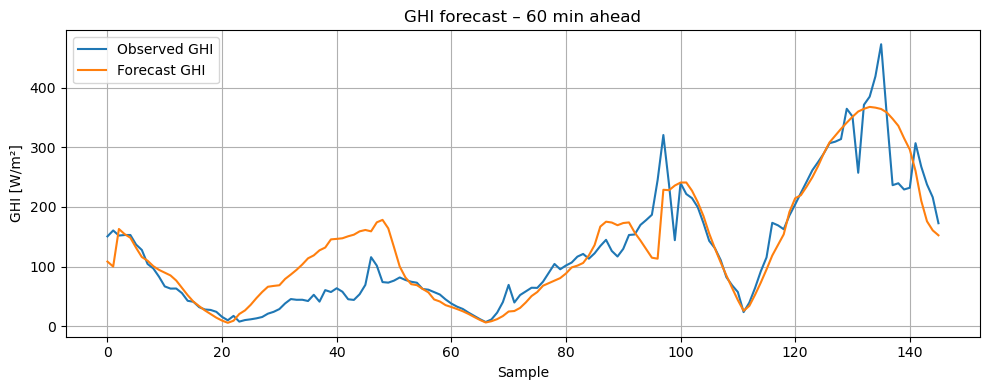

In [14]:
h = 5

plt.figure(figsize=(10,4))
plt.plot(y_true_ghi[:500, h], label="Observed GHI")
plt.plot(y_pred_ghi[:500, h], label="Forecast GHI")
plt.title("GHI forecast – 60 min ahead")
plt.xlabel("Sample")
plt.ylabel("GHI [W/m²]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(PLOT_DIR / "forecast_60min.png")
plt.show()
